In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
app_train = pd.read_csv('data/application_train.csv')
app_test = pd.read_csv('data/application_test.csv')
bureau = pd.read_csv('data/bureau.csv')
bureau_balance = pd.read_csv('data/bureau_balance.csv')
pos_cash_balance = pd.read_csv('data/POS_CASH_balance.csv')

previous_app = pd.read_csv('data/previous_application.csv')
installments_payments = pd.read_csv('data/installments_payments.csv')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv')

Все задания выполняются на датасете Home credit на kaggle
0. Взять три гиперпараметра для решающего дерева, и для каждого проварьировать один изних, фиксирую остальные. Построить графики зависимости метрики на кросс-валидации от параметра.
1. Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров для решающего дерева (без фанатизма, не стоит делать слишком долгие переборы). Какие параметры дают наилучший результат?

2. Аналогично сделать пункты 0-1 для cлучайного леса
3. С помощью случайного леса получить оценку важности признаков. Какие признаки влияют больше всего на результат?
4. Допусти вы построили модель на M признаках. Теперь отберите только 5 самых важных и постройте модель только на них. Как изменилась метрика на кросс-валидации? Прокомментируйте.
5. Постройте модель на M-1 признаке, исключая самый важный. Как изменилась метрика на кросс-валидации? Прокомментируйте.

In [3]:
app_test.shape

(48744, 121)

Предобработка данных

In [4]:
#Сгрупируем клиентов по их id, посчитаем сколько кредитов им выдавалось и переименуем колонки для удобства
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


Воспользумся функционалом Python и напишем функцию для цифровизации и нормализации категориальных данных

In [5]:
def normalize_categorical(df, group_var, col_name):
    
    """Вычисляет количество и нормализованное количество для каждого наблюдения
     group_var для каждой уникальной категории в каждой категориальной переменной
    
     Параметры
     ----------
     df - DataFrame, для которого мы будем рассчитывать количество
    
     group_var = строка
         Переменная, по которой следует сгруппировать фрейм данных. Для каждого уникального
         значение этой переменной, окончательный фрейм данных будет иметь одну строку
        
     col_name = строка
             Переменная добавляется перед именами столбцов для отслеживания столбцов
            """
    # выбераем колонки с категориальными признаками
    categorical = pd.get_dummies(df.select_dtypes('object'))
    
    # Нельзя забывать про колонку id, иначе мы потеряем связь признака с клиентом
    categorical[group_var] = df[group_var]
    
    # Сгруппируем по признаку и посчитаем сумму и среднее
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])                                              
    
    column_names = []
    
    # Иттерируемся по колонкам первого уровня
    for var in categorical.columns.levels[0]:
        # Иттерируемся по колонкам второго уровня
        for stat in ['count', 'count_norm']:
            # Создаем новые имена колонкам
            column_names.append('%s_%s_%s' % (col_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [6]:
bureau_counts = normalize_categorical(bureau, group_var = 'SK_ID_CURR', col_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


Для дальнейшей обработки данных, следует сгрупировать данные по клиентам

In [7]:
data_bureau_agg=bureau.groupby(by='SK_ID_CURR').mean()
data_credit_card_balance_agg=credit_card_balance.groupby(by='SK_ID_CURR').mean()
data_previous_application_agg=previous_app.groupby(by='SK_ID_CURR').mean()
data_installments_payments_agg=installments_payments.groupby(by='SK_ID_CURR').mean()
data_POS_CASH_balance_agg=pos_cash_balance.groupby(by='SK_ID_CURR').mean()

data_bureau_agg.head()

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
SK_ID_CURR,,,,,,,,,,,,,
100001,5896633.000,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,0.0,-93.142857,3545.357143
100002,6153272.125,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,0.0,-499.875000,0.000000
100003,5885878.500,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,0.0,-816.000000,NaN
100004,6829133.500,-867.000000,0.0,-488.500000,-532.500000,0.000,0.0,94518.900000,0.000000,0.00000,0.0,-532.000000,NaN
100005,6735201.000,-190.666667,0.0,439.333333,-123.000000,0.000,0.0,219042.000000,189469.500000,0.00000,0.0,-54.333333,1420.500000


Сделав стандартные преобразования для наших данных, посмотрим что в них более приятным и ясным для глаза способом

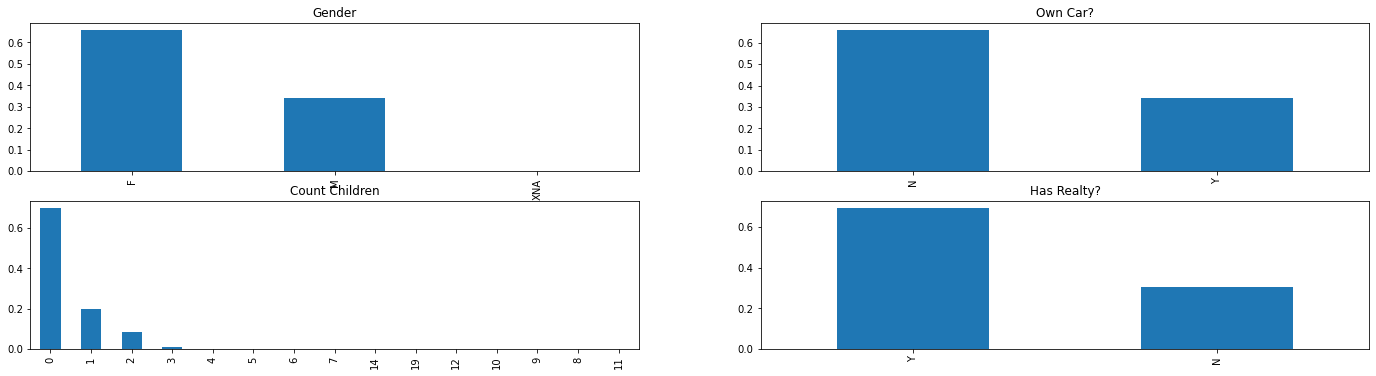

In [8]:
plt.figure(1)
plt.subplot(221)
app_train['CODE_GENDER'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Gender')

plt.subplot(222)
app_train['FLAG_OWN_CAR'].value_counts(normalize=True).plot.bar(title= 'Own Car?')

plt.subplot(223)
app_train['CNT_CHILDREN'].value_counts(normalize=True).plot.bar(title= 'Count Children')

plt.subplot(224)
app_train['FLAG_OWN_REALTY'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'Has Realty?')



plt.show()

**Вывод**


*   Мы видим, что большинство претендентов были женского пола и не имели детей.
*   Интересен тот факт, что большинство претендентов владели недвижимостью, но не автомобилем.








Объединим тренировочные и тестовые данные

In [9]:
def merge(df):
    df = df.join(data_bureau_agg, how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2') 
    df = df.join(bureau_counts, on = 'SK_ID_CURR', how = 'left')
    df = df.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
    df = df.join(data_credit_card_balance_agg, how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2')    
    df = df.join(data_previous_application_agg, how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2')   
    df = df.join(data_installments_payments_agg, how='left', on='SK_ID_CURR', lsuffix='1', rsuffix='2') 
    
    return df

train = merge(app_train)
test = merge(app_test)
display(train.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,...,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-25.000000,-17.000000,0.000000,1.038818e+06,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1054.333333,-1047.333333,0.666667,2.290070e+06,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-724.000000,-714.000000,0.000000,1.564014e+06,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,182477.500000,182481.750000,0.000000,2.217428e+06,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,72136.200000,72143.800000,0.600000,2.048985e+06,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227


Объединим их

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.TARGET.values

#train_df = train_df.drop

all_data = pd.concat([train, test]).reset_index(drop=True)
all_data.drop(['TARGET'], axis=1, inplace=True)

In [11]:
# Теперь мы конвертируем дни занятости и дни регистрации и дни публикации идентификатора в положительное число. 
def correct_birth(df):
    
    df['DAYS_BIRTH'] = round((df['DAYS_BIRTH'] * (-1))/365)
    return df

def convert_abs(df):
    df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'])
    df['DAYS_REGISTRATION'] = abs(df['DAYS_REGISTRATION'])
    df['DAYS_ID_PUBLISH'] = abs(df['DAYS_ID_PUBLISH'])
    df['DAYS_LAST_PHONE_CHANGE'] = abs(df['DAYS_LAST_PHONE_CHANGE'])
    return df

# Теперь заполним недостающие значения в OWN_CAR_AGE. 
# Заполним нулями

def missing(df):
    
    features = ['previous_loan_counts','NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_MEDI','OWN_CAR_AGE']
    
    for f in features:
        df[f] = df[f].fillna(0 )
    return df

def transform_app(df):
    df = correct_birth(df)
    df = convert_abs(df)
    df = missing(df)
    return df

   

all_data = transform_app(all_data)

In [12]:
# подсчитывая количество телефонов, предоставленных компанией, и удаляя ненужные признаки
all_data['NO_OF_CLIENT_PHONES'] = all_data['FLAG_MOBIL'] + all_data['FLAG_EMP_PHONE'] + all_data['FLAG_WORK_PHONE']
all_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,...,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NO_OF_CLIENT_PHONES
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,-17.000000,0.000000,1.038818e+06,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,2
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,-1047.333333,0.666667,2.290070e+06,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,2
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,-714.000000,0.000000,1.564014e+06,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,182481.750000,0.000000,2.217428e+06,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438,2
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,72143.800000,0.600000,2.048985e+06,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227,2


In [13]:
# добавим признак, чтобы определить, совпадает ли город проживания клиента с городом регистрации и работы
all_data['FLAG_CLIENT_OUTSIDE_CITY'] = np.where((all_data['REG_CITY_NOT_WORK_CITY']==1) & (all_data['REG_CITY_NOT_LIVE_CITY']==1),1,0)
all_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,...,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NO_OF_CLIENT_PHONES,FLAG_CLIENT_OUTSIDE_CITY
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.000000,1.038818e+06,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,2,0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.666667,2.290070e+06,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,2,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.000000,1.564014e+06,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.000000,2.217428e+06,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438,2,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.600000,2.048985e+06,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227,2,0


In [14]:
# удаление уже не нужных признаков
def delete(df):
   # useless=['FLAG_MOBIL', 'FLAG_EMP_PHONE' ,'FLAG_WORK_PHONE','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION']
  return df.drop(['FLAG_MOBIL', 'FLAG_EMP_PHONE' ,'FLAG_WORK_PHONE','REG_CITY_NOT_WORK_CITY','REG_CITY_NOT_LIVE_CITY','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION'], axis=1)
def transform(df):
   # df = convert_abs(df)
   df = delete(df)
   
   return df

all_data = transform(all_data)
all_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,...,NFLAG_INSURED_ON_APPROVAL,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NO_OF_CLIENT_PHONES,FLAG_CLIENT_OUTSIDE_CITY
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.000000,1.038818e+06,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,2,0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.666667,2.290070e+06,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,2,0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.000000,1.564014e+06,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.000000,2.217428e+06,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438,2,0
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.600000,2.048985e+06,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227,2,0


In [15]:
# удалим id

def delete_id(df):
    return df.drop(['SK_ID_CURR', 'SK_ID_PREV','SK_ID_BUREAU'], axis = 1)

all_data = delete_id(all_data)

In [16]:
# обработка отсутствующих значений

def miss_numerical(df):
    
    features = ['previous_loan_counts','NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_MEDI','OWN_CAR_AGE']
    numerical_features = all_data.select_dtypes(exclude = ["object"] ).columns
    for f in numerical_features:
        if f not in features:
            df[f] = df[f].fillna(df[f].median())
      
    return df

def miss_categorical(df):
    
    categorical_features = all_data.select_dtypes(include = ["object"]).columns
    
    for f in categorical_features:
        df[f] = df[f].fillna(df[f].mode()[0])
        
    return df

def transform_feature(df):
    df = miss_numerical(df)
    df = miss_categorical(df)
    return df

all_data = transform_feature(all_data)


all_data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,NAME_TYPE_SUITE,...,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NO_OF_CLIENT_PHONES,FLAG_CLIENT_OUTSIDE_CITY
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,-17.000000,0.000000,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,2,0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,-1047.333333,0.666667,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000,2,0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,-714.000000,0.000000,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,3,0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,182481.750000,0.000000,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438,2,0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,72143.800000,0.600000,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227,2,0


In [17]:
# Масштабирование данных
from sklearn.preprocessing import MinMaxScaler

def encoder(df):
    scaler = MinMaxScaler()
    numerical = all_data.select_dtypes(exclude = ["object"]).columns
    features_transform = pd.DataFrame(data= df)
    features_transform[numerical] = scaler.fit_transform(df[numerical])
    display(features_transform.head(n = 5))
    return df

all_data = encoder(all_data)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT1,AMT_ANNUITY1,AMT_GOODS_PRICE1,NAME_TYPE_SUITE,...,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,NO_OF_CLIENT_PHONES,FLAG_CLIENT_OUTSIDE_CITY
0,Cash loans,M,N,Y,0.0,0.001512,0.090287,0.090032,0.077441,Unaccompanied,...,0.007702,0.000000,0.026991,0.062846,0.899966,0.898168,0.004615,0.004615,0.666667,0.0
1,Cash loans,F,N,N,0.0,0.002089,0.311736,0.132924,0.271605,Family,...,0.004903,0.666667,0.026667,0.028490,0.528893,0.549439,0.025854,0.025854,0.666667,0.0
2,Revolving loans,M,Y,Y,0.0,0.000358,0.022472,0.020025,0.023569,Unaccompanied,...,0.005808,0.000000,0.034188,0.006983,0.742720,0.752716,0.002833,0.002833,1.000000,0.0
3,Cash loans,F,N,Y,0.0,0.000935,0.066837,0.109477,0.063973,Unaccompanied,...,0.503494,0.000000,0.028846,0.024004,0.914611,0.912443,0.025133,0.025133,0.666667,0.0
4,Cash loans,M,N,Y,0.0,0.000819,0.116854,0.078975,0.117845,Unaccompanied,...,0.203740,0.600000,0.029915,0.042214,0.648645,0.664523,0.005057,0.004877,0.666667,0.0


In [18]:
# Преобразование категориальных признаков

# LabelEncoder наше все(переводит категориальные признаки из типа 'object' в тип 'int')
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0


# Иттерируемся по всем колонкам
for col in all_data:
    if all_data[col].dtype == 'object':
        # Если две и меньше категории
        if len(list(all_data[col].unique())) <= 2:
            # Учим наш LabelEncoder на тренировочных данных
            le.fit(all_data[col])
            # Преобразовываем датасет
            all_data[col] = le.transform(all_data[col])
            
            
            # Посмотрим сколько колонок мы преобразовали
            le_count += 1
           
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [19]:
all_data = pd.get_dummies(all_data)

display(all_data.shape)

(356255, 341)

In [20]:
# разделим датасет
train = all_data[:ntrain]
test = all_data[ntrain:]

print("Training shape", train.shape)
print("Testing shape", test.shape)

Training shape (307511, 341)
Testing shape (48744, 341)


In [21]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(train, y_train, test_size = 0.3, random_state = 200)
print("X Training shape", X_train.shape)
print("X Testing shape", X_test.shape)
print("Y Training shape", Y_train.shape)
print("Y Testing shape", Y_test.shape)

X Training shape (215257, 341)
X Testing shape (92254, 341)
Y Training shape (215257,)
Y Testing shape (92254,)


Здесь начинается решение поставленных задач, предыдущие действия продублированны из предыдущего домашнего задания

Для начала сделаем импорт недостояющих библиотек

In [22]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

Построим модель решающего дерева и запишем параметры, по которым мы прогоним модель на поиск лучших параметров через  ПкшвЫуфксрСМ

In [22]:
model = DecisionTreeClassifier()
parameters = {
    'splitter': ['best', 'random'],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=-1, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed: 43.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 60.1min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 92.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | ela

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=5)

In [23]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=20)

 Получили параметры для последующего обучения нашей модели.
 
 Далее решим задачу проверки как зависят метрики от изменения одного из параметров в модели, для этого нам понадобится следующая функция

In [23]:
def my_cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    return scores

In [24]:
max_depth = [1, 3, 5, 7, 9]
min_samples_split = [2, 4, 10, 20]
min_samples_leaf = [1, 3, 5, 7]

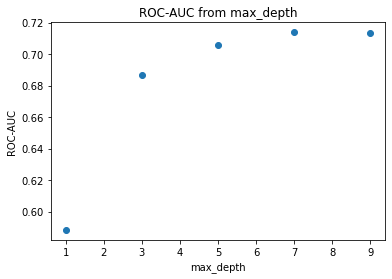

In [26]:
score_max_depth = []
for i in max_depth:
    model = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=20, max_depth=i)
    score_max_depth.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_depth, score_max_depth)
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_depth')
plt.show()

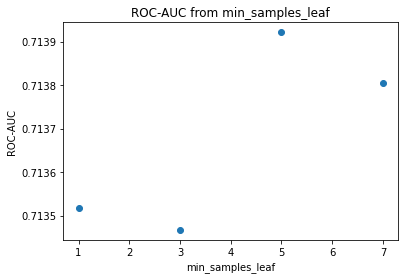

In [25]:
score_min_samples_leaf = []
for i in min_samples_leaf:
    model = DecisionTreeClassifier(min_samples_leaf=i, min_samples_split=20, max_depth=7)
    score_min_samples_leaf.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(min_samples_leaf, score_min_samples_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_samples_leaf')
plt.show()

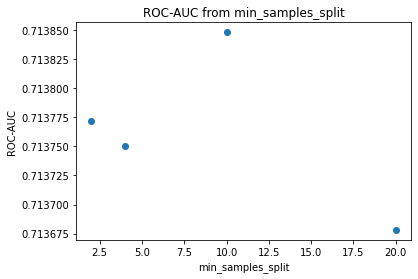

In [29]:
score_min_samples_split = []
for i in min_samples_split:
    model = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=i, max_depth=7)
    score_min_samples_split.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(min_samples_split, score_min_samples_split)
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from min_samples_split')
plt.show()

Из первого графика можно сделать вывод, что разница между глубиной дерева 7 и 9 нет, что нельзя сказать о вычислительной мощности, затрачиваемой на построение модели.

Из второго видно, что наилучший результат показало значение 5, но разница в результатах очень маленькая.

То же самое можно сказать и про последний график.

In [30]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=20)
model.fit(X_train, Y_train)
prediction = model.predict_proba(X_test)
print('Auc score for Decision Tree Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Decision Tree Classifier: 0.7178037509202139


Теперь сделаем аналогичные действия для случайного леса

In [31]:
model = RandomForestClassifier()

parameters = {
    "n_estimators" :[25, 50, 75, 100],
    "max_depth" :[1, 3, 5, 7, 9],
    "max_features" :[1, 2, 3, 4, 5]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=-1, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 14.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 5, 7, 9],
                         'max_features': [1, 2, 3, 4, 5],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='roc_auc', verbose=5)

In [32]:
grid.best_estimator_

RandomForestClassifier(max_depth=9, max_features=5)

In [33]:
n_estimators = [10, 25, 50, 100]
max_depth = [1, 3, 5, 7, 9]
max_features = [1, 2, 3, 4, 5]

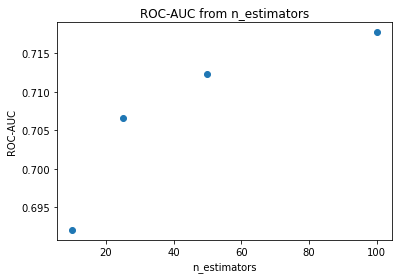

In [35]:
score_n_estimators = []
for i in n_estimators:
    model = RandomForestClassifier(n_estimators=i, max_features=5, max_depth=9)
    score_n_estimators.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(n_estimators, score_n_estimators)
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from n_estimators')
plt.show()

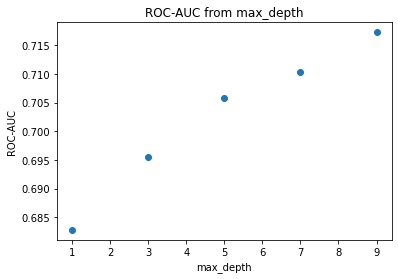

In [37]:
score_max_depth = []
for i in max_depth:
    model = RandomForestClassifier(n_estimators=100, max_features=5, max_depth=i)
    score_max_depth.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_depth, score_max_depth)
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_depth')
plt.show()

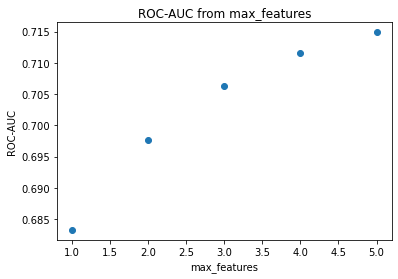

In [39]:
score_max_features = []
for i in max_features:
    model = RandomForestClassifier(n_estimators=100, max_features=i, max_depth=9)
    score_max_features.append(np.mean(my_cross_validation_for_roc_auc(model, X_train, Y_train, 14)))
plt.scatter(max_features, score_max_features)
plt.xlabel('max_features')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC from max_features')
plt.show()

Из графиков можно предположить, что наша выборка гиперпараметров была маленькой и для каких серьезных выводов не подходит, но увеличить ее тяжело, так как очень сильно увеличиваются вычислительные мощности

In [84]:
model = RandomForestClassifier(max_depth=9, max_features=5)
model.fit(X_train, Y_train)
prediction = model.predict_proba(X_test)
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.7198707906886391


Для решения последних двух задач воспользуемся атрибутом случайного леса .feature_importances_ и выведем 5 максимально значимых признака

In [85]:
feature_names = np.array(all_data.columns)

tree_feature_importances = (
    model.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

features = feature_names[sorted_idx[:5]]

features

array(['CODE_GENDER_XNA', 'ORGANIZATION_TYPE_Trade: type 5',
       'bureau_CREDIT_TYPE_Mobile operator loan_count_norm',
       'bureau_CREDIT_TYPE_Real estate loan_count',
       'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm'],
      dtype=object)

In [86]:
model = RandomForestClassifier(max_depth=9, max_features=5)
model.fit(X_train[['CODE_GENDER_XNA', 'ORGANIZATION_TYPE_Trade: type 5',
       'bureau_CREDIT_TYPE_Mobile operator loan_count_norm',
       'bureau_CREDIT_TYPE_Real estate loan_count',
       'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm']], Y_train)
prediction = model.predict_proba(X_test[['CODE_GENDER_XNA', 'ORGANIZATION_TYPE_Trade: type 5',
       'bureau_CREDIT_TYPE_Mobile operator loan_count_norm',
       'bureau_CREDIT_TYPE_Real estate loan_count',
       'bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm']])
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.5000746210463403


Как можно заметить, хоть мы обучали модель только на максимально значимых признаках, но другие признаки тоже оказывают влияние

In [92]:
X_train, X_test = X_train.drop(['CODE_GENDER_XNA'], axis=1), X_test.drop(['CODE_GENDER_XNA'], axis=1)

In [93]:
model = RandomForestClassifier(max_depth=9, max_features=5)
model.fit(X_train, Y_train)
prediction = model.predict_proba(X_test)
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.7191451781347615


Из последнего действия можно предположить, что значимость у всех признаков почти одинаковая